# <center>**Detecting Anomalies in Wafer Manufacturing**</center>
## <center>**检测晶圆制造中的异常情况**<center>
#### 数据集描述：
数据集来自于kaggle(https://www.kaggle.com/datasets/arbazkhan971/anomaly-detection/data)，取自于印度一家领先的晶圆（半导体）制造商的用例，数据集是匿名的，以隐藏特征名称  
Train.csv - 1763 行 x 1559 列  
Test.csv - 756 行 x 1558 列  
Sample Submission.csv - 756行 x 1列 测试样品数据标签  
#### 属性描述：  
Feature_1 - Feature_1558 - 表示从制造机器收集的各种属性  
Class - （0 或 1） - 表示产品的良好/异常类别标签  
#### 采用机器学习方法：  
高维数据降维  
特征工程、特征选择  
多模型比较选择  
超参数调优  
优化曲线下面积（AUC）、f1-score以评判模型  

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_data = pd.read_csv('Train.csv')
x_train = train_data.drop('Class', axis=1)
y_train = train_data['Class']

x_test = pd.read_csv('Test.csv')
y_test = pd.read_csv('Sample_submission.csv')

#### 导入前期数据探索所需包以及训练集与测试集

In [4]:
print(train_data.head())
print(train_data.info())

   feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0        100        160     1.6000          0          0          0   
1         20         83     4.1500          1          0          0   
2         99        150     1.5151          1          0          0   
3         40         40     1.0000          0          0          0   
4         12        234    19.5000          1          0          0   

   feature_7  feature_8  feature_9  feature_10  ...  feature_1550  \
0          0          0          0           0  ...             0   
1          0          0          0           1  ...             0   
2          0          0          0           0  ...             0   
3          0          0          0           0  ...             0   
4          0          0          0           0  ...             0   

   feature_1551  feature_1552  feature_1553  feature_1554  feature_1555  \
0             0             0             0             0             0   
1       

#### 初步探索结果：
feature_3为float64类型，其余为int64类型；  
且此处可看到feature_4--feature_1558显示部分都为0/1，考虑其为类别型变量即非0则1，后续探索；  
feature_1--feature_2为数值型变量，后续考虑用条形图绘制探索。  

In [ ]:
from ydata_profiling import ProfileReport
Profile = ProfileReport(train_data, minimal=True, pool_size=6, correlations=None, interactions=None)
Profile.to_file('report.html')

#### 导入ydata_profiling包
生成html文件，内容为train_data的数据探索情况，可在生成html文件中查看，高度自由，但所需时间较长  

In [16]:
i = 0
for col in x_train.columns[3:]:
    if len(x_train[col].unique()) == 2:
        i += 1
    else:
        print(col, ': count ', len(x_train[col].unique()))
print('类别型变量个数：', i)

feature_57 : count  1
feature_82 : count  1
feature_106 : count  1
feature_147 : count  1
feature_262 : count  1
feature_278 : count  1
feature_284 : count  1
feature_320 : count  1
feature_362 : count  1
feature_372 : count  1
feature_383 : count  1
feature_435 : count  1
feature_439 : count  1
feature_488 : count  1
feature_495 : count  1
feature_522 : count  1
feature_531 : count  1
feature_553 : count  1
feature_578 : count  1
feature_591 : count  1
feature_630 : count  1
feature_631 : count  1
feature_652 : count  1
feature_894 : count  1
feature_934 : count  1
feature_978 : count  1
feature_1038 : count  1
feature_1063 : count  1
feature_1096 : count  1
feature_1185 : count  1
feature_1211 : count  1
feature_1243 : count  1
feature_1247 : count  1
feature_1341 : count  1
feature_1367 : count  1
feature_1407 : count  1
类别型变量个数： 1519


输出feature_4--feature_1558显示部分是否都为0/1

count    1763.000000
mean       53.094158
std        55.842014
min         1.000000
25%        12.000000
50%        39.000000
75%        75.000000
max       640.000000
Name: feature_1, dtype: float64


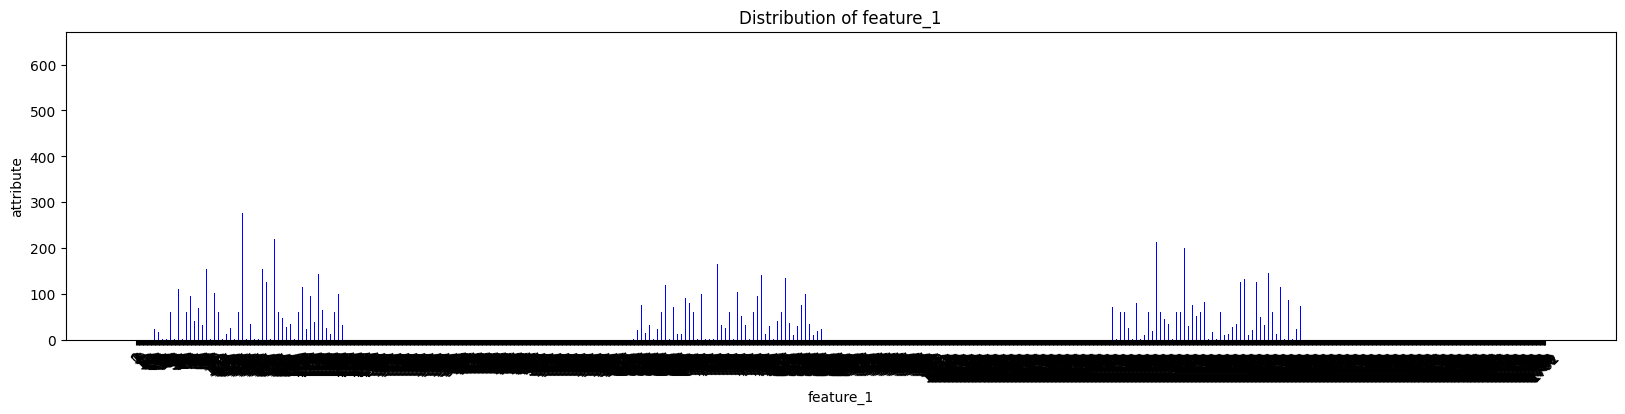

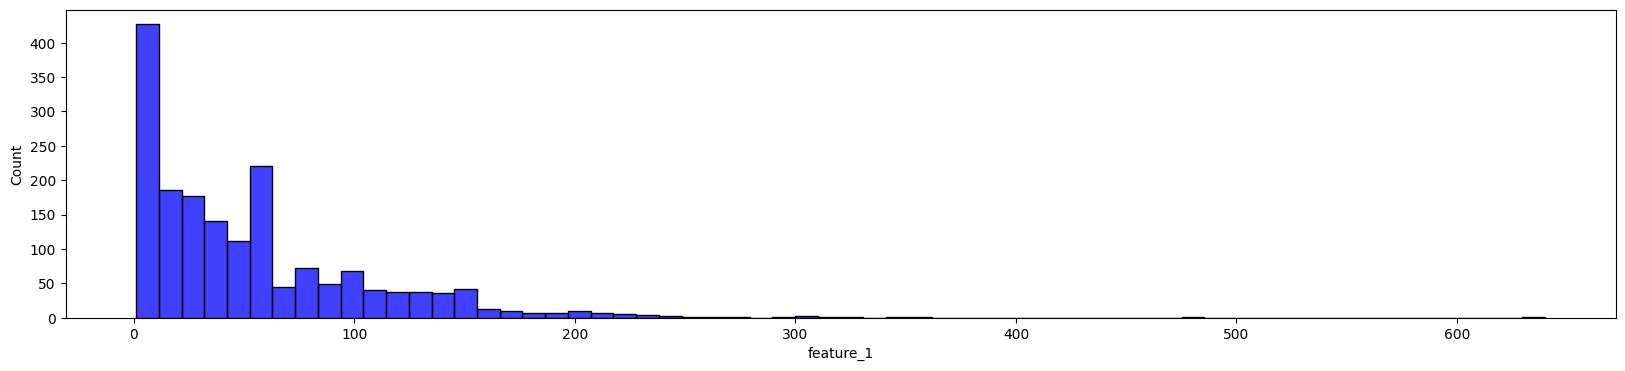

count    1763.000000
mean      126.587067
std       129.859641
min         1.000000
25%        33.500000
50%        96.000000
75%       159.000000
max       640.000000
Name: feature_2, dtype: float64


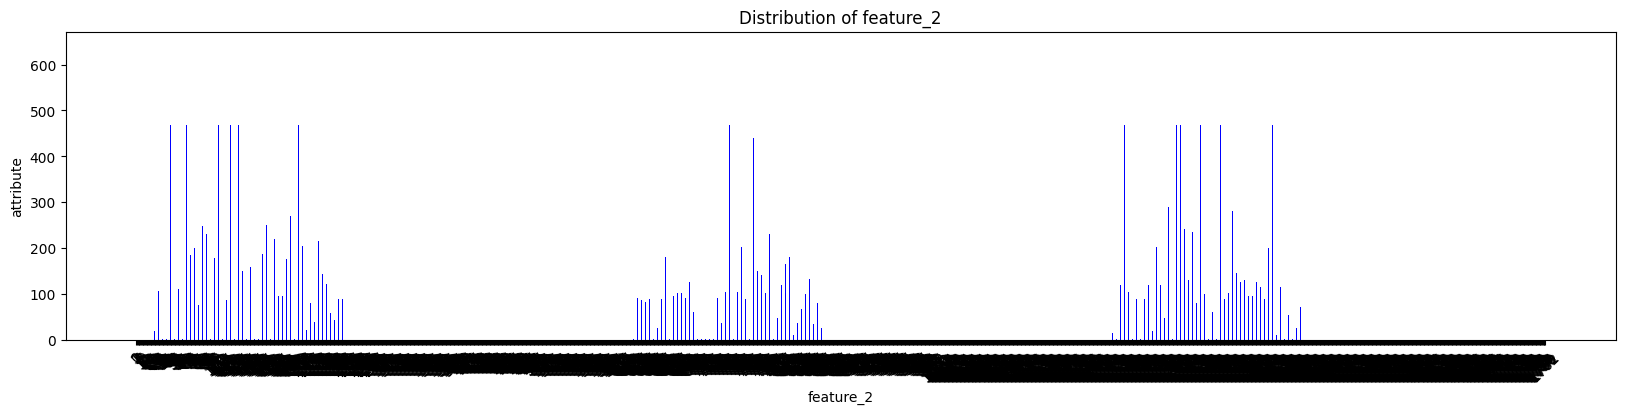

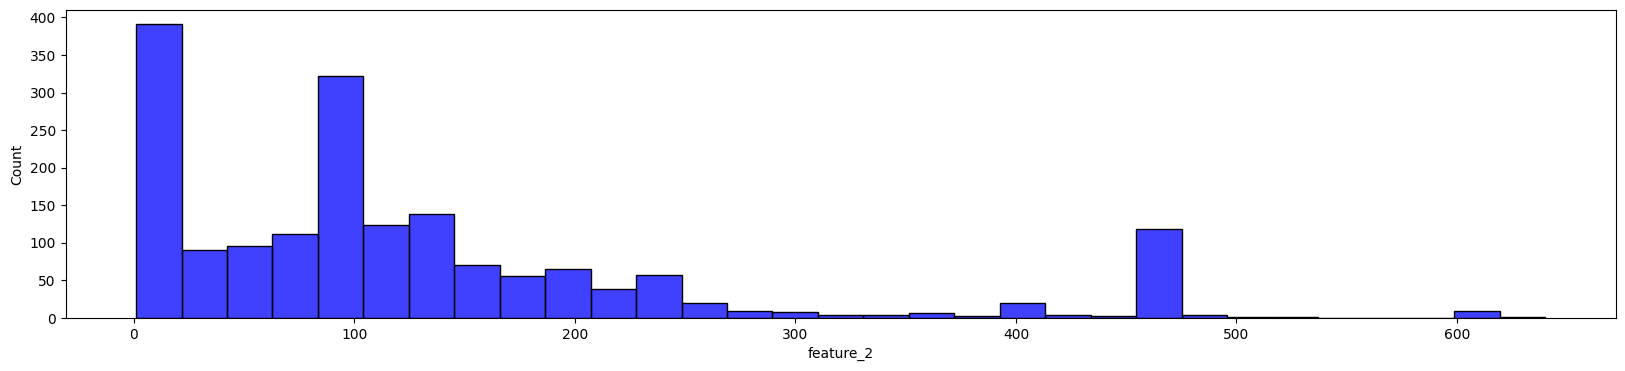

count    1763.000000
mean        3.423940
std         4.566858
min         0.001500
25%         1.250000
50%         2.000000
75%         4.500000
max        60.000000
Name: feature_3, dtype: float64


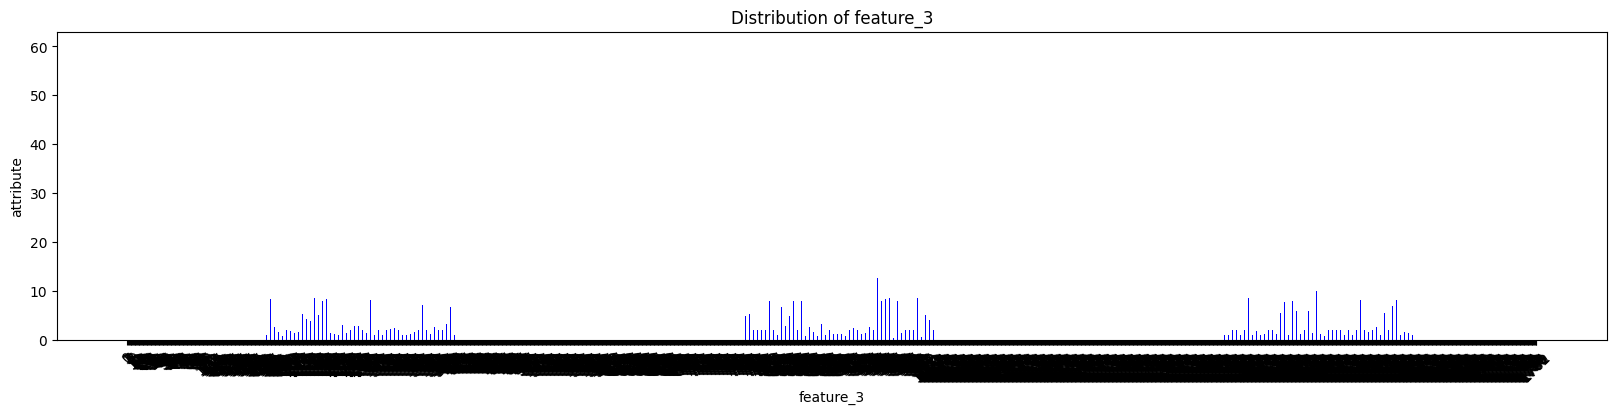

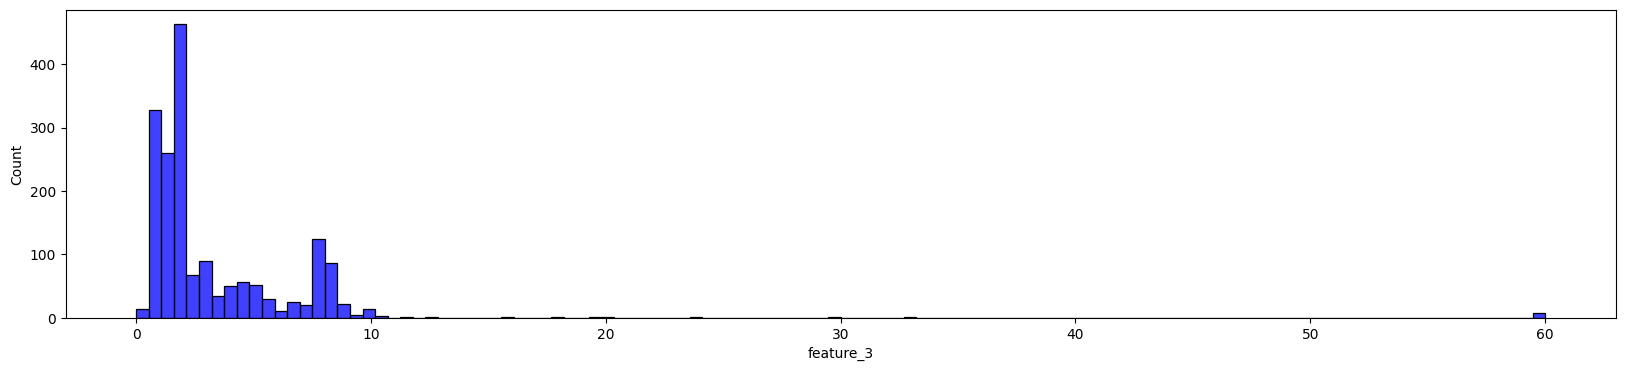

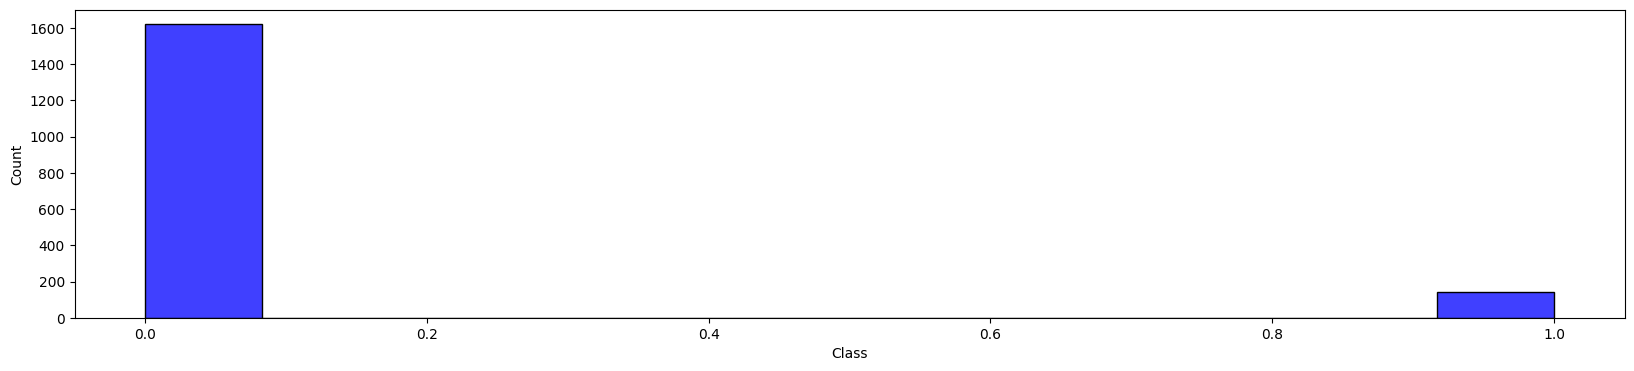

In [41]:
%matplotlib inline

def hist_plot(data, color):
    plt.figure(figsize=(20, 4))
    sns.histplot(data, color=color)
    plt.show()

for col in x_train.columns[:3]:
    print(x_train[col].describe())
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(range(len(x_train[col])), x_train[col], color='b', width=0.1)
    ax.set_xlabel(col)
    ax.set_ylabel('attribute')
    ax.set_title(f'Distribution of {col}')
    ax.set_xticks(range(len(x_train[col])))
    ax.set_xticklabels(x_train[col].index, rotation=45)
    plt.show()
    hist_plot(x_train[col], color='b')

hist_plot(y_train, color='b')

#### 进一步探索
由图及描述可知，数据集样本标签高度不平衡，在降维后进行smote过采样保证类别平衡

In [135]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaler = scaler.fit_transform(x_train)
pca = PCA(n_components=0.95)
pca.fit(x_train_scaler)
x_train_pca = pca.fit_transform(x_train_scaler)
print('Number of components:', pca.n_components_)

Number of components: 304


#### 数据降维处理使用方法一：PCA
使用sklearn库中PCA直接进行降维处理，通过设置解释的总方差比例阈值得到最佳维度

Text(0, 0.5, 'feature_importance')

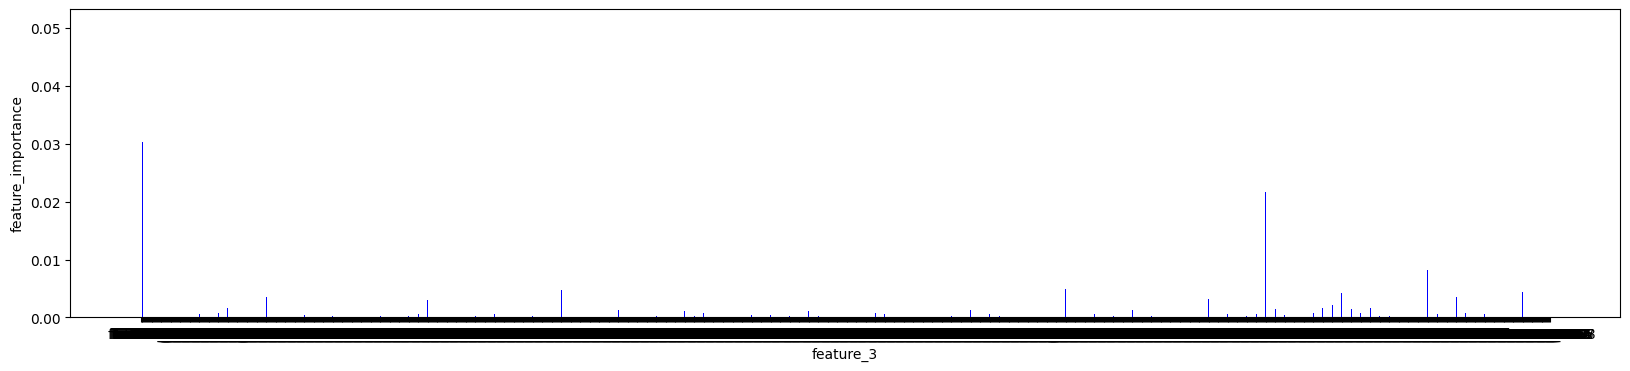

In [46]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=16, n_jobs=-1)
rnd_clf.fit(x_train, y_train)

fig, ax = plt.subplots(figsize=(20, 4))
ax.bar(x_train.columns, rnd_clf.feature_importances_, color='b', width=0.1)
ax.set_xlabel(col)
ax.set_ylabel('feature_importance')

<Axes: ylabel='Count'>

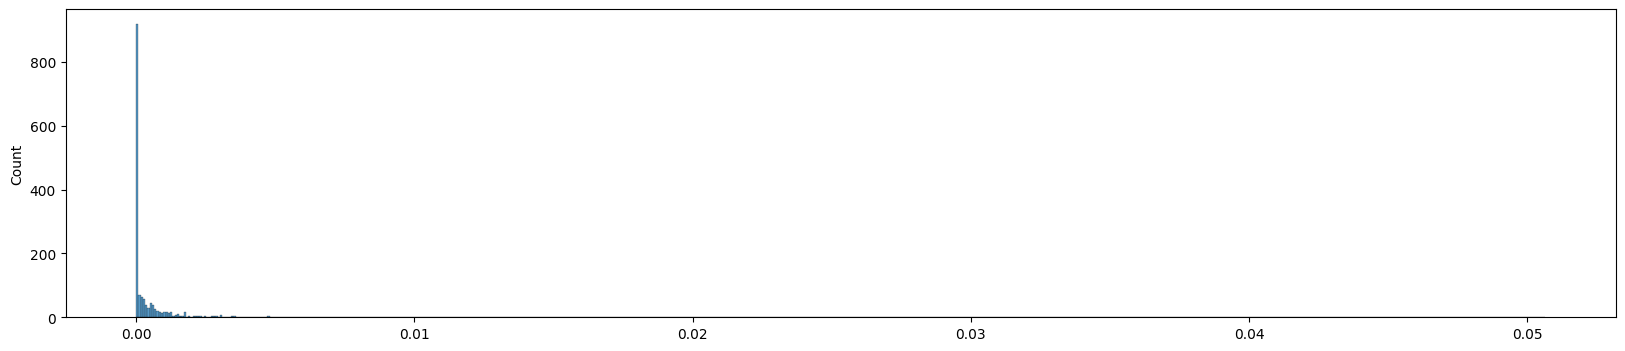

In [47]:
plt.figure(figsize=(20,4))
sns.histplot(rnd_clf.feature_importances_)

In [52]:
x_train_rnd = x_train.loc[:, rnd_clf.feature_importances_>0.001]
print(len(x_train_rnd.columns))

220


#### 数据降维处理使用方法二：通过随机森林所得特征重要性筛选
使用sklearn库进行随机森林计算特征重要性，通过设置阈值得到合格特征

In [145]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy=0.7, random_state=1)
x_train_pca_rs ,y_train_rs = sm.fit_resample(x_train_pca, y_train)

scaler = StandardScaler()
x_test_scaler = scaler.fit_transform(x_test)
x_test_pca = pca.transform(x_test)

由于随机森林生成的特征重要性多数不明显，选择PCA为降维方法，并将测试集同时进行降维处理

In [143]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score

#### 模型选择：
此处选择了logitic回归、随机森林、GBRT、XGboost

In [147]:
parameters = {'penalty':['l1','l2'],
              'C': [0.001, 0.01]}
# Logistic Regression
GD_LR = GridSearchCV(LogisticRegression(solver='liblinear'),
                        param_grid=parameters, 
                        scoring='roc_auc')
#Random Forest
parameters = {
            'max_leaf_nodes': [i for i in range(5,10)],
            'max_depth': [i for i in range(5,10)]}
GD_RF = GridSearchCV(RandomForestClassifier(class_weight="balanced"),
                     param_grid=parameters, 
                     scoring='roc_auc')
models = {'Logistic_Regression': GD_LR,
          'Random_Forest': GD_RF,
          }

In [148]:
best = []
for name, model in models.items():
    model.fit(x_train_pca_rs, y_train_rs)
    print(name, model.best_params_, model.best_estimator_, model.best_score_)
    best.append([name, model.best_params_, model.best_estimator_, model.best_score_])

Logistic_Regression {'C': 0.01, 'penalty': 'l2'} LogisticRegression(C=0.01, solver='liblinear') 0.9407346523683768
Random_Forest {'max_depth': 9, 'max_leaf_nodes': 9} RandomForestClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=9) 0.9506630790992674


LogisticRegression(C=0.01, solver='liblinear') : 0.9212522045855379
RandomForestClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=9) : 0.8983245149911816


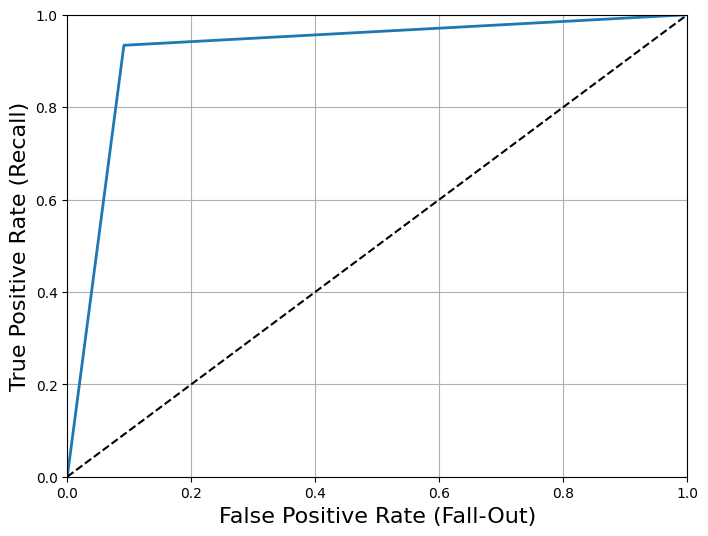

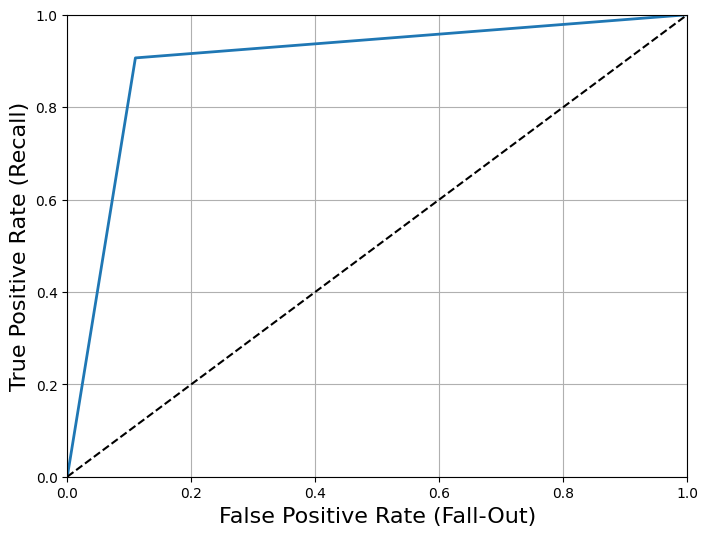

In [149]:
col = ['name', 'params', 'estimators', 'score']
best = pd.DataFrame(best, columns=col)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

for model in best['estimators']:
    model.fit(x_train_pca_rs, y_train_rs)
    y_train_pred = model.predict(x_train_pca_rs)
    print(model, ':', roc_auc_score(y_train_rs, y_train_pred))
    fpr, tpr, thresholds = roc_curve(y_train_rs, y_train_pred)
    plt.figure(figsize=(8,6))
    plot_roc_curve(fpr, tpr)
    plt.show
    

In [150]:
#Gradient Boosting
gbrt = GradientBoostingClassifier(max_depth=2, warm_start=True)
max_auc_score = float('-inf')
auc_score_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators_ = n_estimators
    gbrt.fit(x_train_pca_rs, y_train_rs)
    y_train_pred = gbrt.predict(x_train_pca_rs)
    auc_score = roc_auc_score(y_train_rs, y_train_pred)
    if auc_score > max_auc_score:
        max_auc_score = auc_score
        auc_score_up = 0
    else:
        auc_score_up += 1
        if auc_score_up == 5:
            print('n_estimators:', gbrt.n_estimators_ - 5, 'auc_score:', max_auc_score)
            break

n_estimators: 96 auc_score: 0.950705467372134


0.9502204585537919


<function matplotlib.pyplot.show(close=None, block=None)>

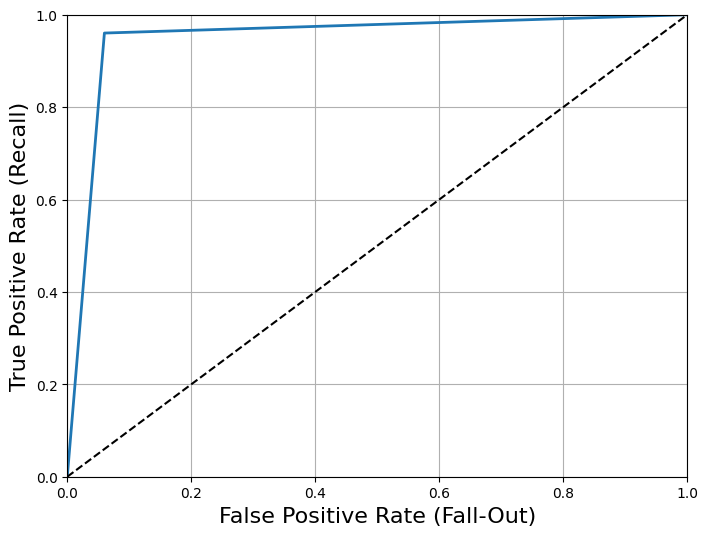

In [151]:
gbrt = GradientBoostingClassifier(n_estimators=96, max_depth=2, warm_start=True)
gbrt.fit(x_train_pca_rs, y_train_rs)
y_train_pred = gbrt.predict(x_train_pca_rs)
fpr, tpr, thresholds = roc_curve(y_train_rs, y_train_pred)
print(roc_auc_score(y_train_rs, y_train_pred))
plt.figure(figsize=(8,6))
plot_roc_curve(fpr, tpr)
plt.show

0.9957671957671957


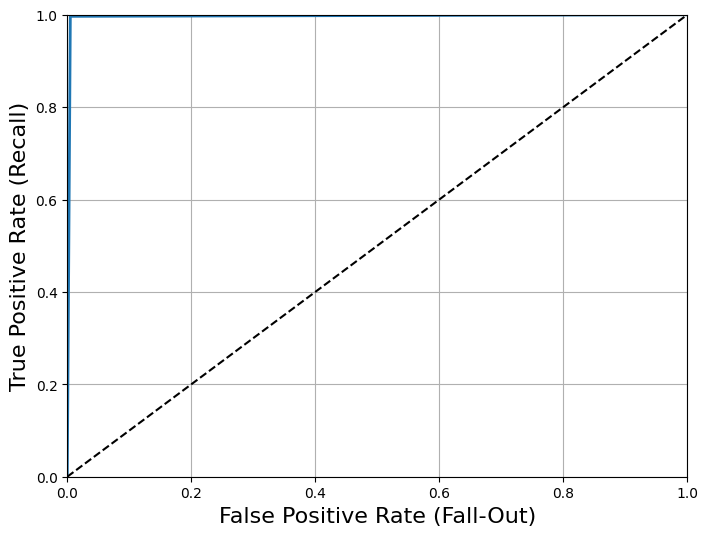

In [152]:
xgb_reg = xgb.XGBClassifier()
xgb_reg.fit(x_train_pca_rs, y_train_rs)
y_train_pred = xgb_reg.predict(x_train_pca_rs)
print(roc_auc_score(y_train_rs, y_train_pred))
fpr, tpr, thresholds = roc_curve(y_train_rs, y_train_pred)
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr) # type: ignore

#### 超参数调优：
对Logistic、随机森林、GBRT进行超参数调优
XGboost则直接进行训练
#### 训练集上调优结果：
Logistic: 最优参数为LogisticRegression(C=0.01, penalty='l1', solver='liblinear')， 在训练集上计算得到的ROC曲线面积为: 0.92  
随机森林：最优参数为RandomForestClassifier(class_weight='balanced', max_depth=9, max_leaf_nodes=9)，在训练集上得到的ROC曲线面积: 0.89  
GBRT：最优参数为GradientBoostingClassifier(n_estimators=96, max_depth=2, warm_start=True)，在训练集上得到的ROC曲线面积为0.95  
XGboost：在训练集上得到的ROC曲线面积为0.99  

In [153]:
log = LogisticRegression(C=0.01, penalty='l1', solver='liblinear')
log.fit(x_train_pca_rs, y_train_rs)
y_pred = log.predict(x_test_pca)
print(confusion_matrix(y_test, y_pred))

rf = RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9)
rf.fit(x_train_pca_rs, y_train_rs)
y_pred = rf.predict(x_test_pca)
print(confusion_matrix(y_test, y_pred))

gbrtc = GradientBoostingClassifier(n_estimators=96, max_depth=2, warm_start=True)
gbrtc.fit(x_train_pca_rs, y_train_rs)
y_pred = gbrtc.predict(x_test_pca)
print(confusion_matrix(y_test, y_pred))

xgbc = xgb.XGBClassifier()
xgbc.fit(x_train_pca_rs, y_train_rs)
y_pred = xgbc.predict(x_test_pca)
print(confusion_matrix(y_test, y_pred))


[[173 583]
 [  0   0]]
[[ 56 700]
 [  0   0]]
[[578 178]
 [  0   0]]
[[574 182]
 [  0   0]]


In [144]:
models = [LogisticRegression(C=0.01, penalty='l1', solver='liblinear'), RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9), 
          GradientBoostingClassifier(n_estimators=96, max_depth=2, warm_start=True), xgb.XGBClassifier()]
for model in models:
    model.fit(x_train_pca_rs, y_train_rs)
    y_test_pred = model.predict(x_test_pca)
    print(model, ':', accuracy_score(y_test, y_test_pred))

LogisticRegression(C=0.01, penalty='l1', solver='liblinear') : 0.21693121693121692
RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=9) : 0.03571428571428571
GradientBoostingClassifier(max_depth=2, n_estimators=96, warm_start=True) : 0.7645502645502645
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_paralle

#### 分析结果与思考
最终结果上XGBoost更胜一筹，无论是在训练集还是测试集，XGBoost都有更好的鲁棒性，这与该算法基本逻辑上的多次优化有关。  

尽管如此，在最后的测试集上最终只有GBRT与XGBoost准确率在0.75以上，而其他两个最低的仅有0.03，造成这样的原因很大概率是因为数据集的严重不平衡导致的。即使进行过采样后，样本的差异缩小了，但是SMOTE算法基本逻辑是在原数据上进行的，生成的信数据泛化性仍然不足。  
解决这一问题，可以考虑再收集更多数据的基础上进行欠采样，以保证两类数据都有足够的数量进行训练模型。  
